# Data Cleaning & Processing (HEV trips)

Import necessary libraries.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import warnings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

%matplotlib inline
%run utils.py

Define the `Raw Data` and `Processed Data` folders.

In [2]:
path_home = os.path.abspath(os.getcwd())
path_raw_data = os.path.join(path_home, 'Raw Data', 'Class I - HEV')
path_processed_data = os.path.join(path_home, 'Processed Data', 'Class I - HEV')

Enter the `trip name` as it appears in the folder name. To get the list of the folders under `Raw Data` folder, type `os.listdir(path_raw_data)`.

In [3]:
# vehicle = 'Chevrolet Volt 2015 PHEV (August 2022)'
# vehicle = 'Ford C-Max Energi 2016 PHEV (March 2023) - 1'
# vehicle = 'Ford C-Max Energi 2016 PHEV (March 2023) - 2'
# vehicle = 'Ford C-Max Energi 2016 PHEV (October 2022)'
# vehicle = 'Ford Fusion Energi 2020 PHEV (August 2023)'
# vehicle = 'KIA Niro 2018 HEV (September 2023)'
# vehicle = 'Toyota Corolla Hybrid 2019 HEV (November 2022)'
# vehicle = 'Toyota Prius C 2019 HEV (July 2022)'
vehicle = 'Toyota Prius C 2019 HEV (March 2023)'
# vehicle = 'Toyota Prius Prime 2020 PHEV (June 2022)'
# vehicle = 'Toyota RAV4 Hybrid 2021 HEV (October 2022)'

List the raw data files (.csv) under PEMS and OBD folders.

In [4]:
pems_files = glob.glob(os.path.join(path_raw_data, vehicle, 'PEMS', '*.csv'))
obd_files = glob.glob(os.path.join(path_raw_data, vehicle, 'OBD', '*.csv'))
if not pems_files or not obd_files:
    raise('PEMS and/or OBD measurements are missing for that vehicle!')

## Data cleaning

Read OBD and PEMS raw data files. Convert date and time to pandas datetime object (new column name is DateTime) and sort based on DateTime column. Set DateTime column as index. Check if there are duplicated values in DateTime index and correct the duplicated readings with `duplicate_index_correction()`.

In [5]:
if pems_files:
    pems = pd.concat((pd.read_csv(f, encoding='iso-8859-1', skipinitialspace=True) for f in pems_files), ignore_index=True)
    pems['DateTime'] = pems['Date'] + ' ' + pems['Time']
    pems['DateTime'] = pd.to_datetime(pems['DateTime'], format='%m/%d/%Y %I:%M:%S %p')
    pems.sort_values(by='DateTime', ascending=True, inplace=True)
    pems.set_index('DateTime', inplace=True)
    pems = duplicate_index_correction(pems)
if obd_files:    
    obd = pd.concat((pd.read_csv(f, skipinitialspace=True) for f in obd_files), ignore_index=True)
    obd['DateTime'] = pd.to_datetime(obd['Time'], format='%m/%d/%Y %I:%M:%S.%f %p').dt.floor('S')
    obd.sort_values(by='DateTime', ascending=True, inplace=True)
    obd.set_index('DateTime', inplace=True)
    obd = duplicate_index_correction(obd)

Subset data with the selected variables and rename columns with `subset_and_rename()`. The following two CSV files contain the raw data variable names and the new variable names for the selected variables for the following data processing.
- variable_name_conversion_pems.csv
- variable_name_conversion_obd.csv

In [6]:
if pems_files:
    variable_names_pems = pd.read_csv(os.path.join(path_home, 'variable_name_conversion_pems.csv'))
    pems = subset_and_rename(pems, variable_names_pems)
    print('PEMS dimensions are :', pems.shape)
if obd_files: 
    variable_names_obd = pd.read_csv(os.path.join(path_home, 'variable_name_conversion_obd.csv'))
    obd = subset_and_rename(obd, variable_names_obd)
    print('OBD dimensions are :', obd.shape)

PEMS dimensions are : (20167, 3)
OBD dimensions are : (19750, 14)


`Bag#` column contains values {'Zeroing', '0', 0}. Convert this variable to categorical variable with to levels {'Zeroing', '0'}.

In [7]:
if pems_files:
    pems['Bag#'] = pems['Bag#'].astype('str').astype('category')

There could be duplicated readings with the exact same milliseconds. Duplicates except the first are removed.

In [8]:
if pems_files and (pems[pems.index.duplicated(keep=False)].shape[0] > 0):
    pems = pems[~pems.index.duplicated(keep='first')]
    print('PEMS have duplicated DateTime index. Duplicates except the first are removed.')
    print('PEMS dimensions are :', pems.shape)
if obd_files and (obd[obd.index.duplicated(keep=False)].shape[0] > 0):
    obd = obd[~obd.index.duplicated(keep='first')]
    print('OBD have duplicated DateTime index. Duplicates except the first are removed.')
    print('OBD dimensions are :', obd.shape)

Merge OBD and PEMS along DateTime index.

In [9]:
if pems_files:
    pems.reset_index(inplace=True)
    pems.set_index('DateTime', inplace=True)
if obd_files:
    obd.reset_index(inplace=True)
    obd.set_index('DateTime', inplace=True)
if pems_files and obd_files:
    data = pd.concat([obd, pems], axis=1, join='outer')
    print('Merged data dimensions are :', data.shape)
else: 
    print('OBD and/or PEMS data is missing.')

Merged data dimensions are : (20176, 17)


Remove readings with `Bag# = 'Zeroing'`.

In [10]:
data = data[data['Bag#'] != 'Zeroing']
data.drop(columns=['Bag#'], inplace=True)
print('After Bag# = Zeroing removal merged data dimensions are :', data.shape)

After Bag# = Zeroing removal merged data dimensions are : (20056, 16)


If the PEMS and OBD equipments were not installed and removed at the same time, there may be missing readings in the merged data. Remove rows with all missing PEMS or OBD at the top and bottom of the data.

In [11]:
change = True
old_start_with = 0
old_end_with = 0
while change:
    (start_with, end_with) = find_start_end(data, variable_names_pems, variable_names_obd)
    data = data.loc[start_with:end_with]
    data.reset_index().set_index('DateTime', inplace=True)
    if old_start_with == start_with and old_end_with == end_with:
        change = False
    old_start_with = start_with
    old_end_with = end_with
print('After removing missing readings merged data dimensions are :', data.shape)

After removing missing readings merged data dimensions are : (19749, 16)


Although both equipments were installed, they might not have been turned on and off synchronously, or the trip may not have started. Remove the idling at the beginning and end of the readings.

In [12]:
mask = (data['Vehicle Speed [km.h-1]'] == 0) & (data['GPS Speed [km.h-1]'] == 0)
first = next((i for i, j in enumerate(mask) if j == False), None)
last = next((i for i, j in enumerate(reversed(mask)) if j == False), None)
data.drop(data.index[range(0, first)], axis=0, inplace=True)
data.drop(data.index[range(-1, -1*last, -1)], axis=0, inplace=True)
print('After removing idlings data dimensions are :', data.shape)

After removing idlings data dimensions are : (19736, 16)


Remove readings with faulty Latitude/Longitude/Altitude.

In [13]:
data[['Longitude [deg]', 'Latitude [deg]', 'Altitude [m]']] = data[['Longitude [deg]', 'Latitude [deg]', 'Altitude [m]']].replace([np.inf, -np.inf, 0], np.nan)
data.dropna(subset=['Longitude [deg]', 'Latitude [deg]', 'Altitude [m]'], how='any', inplace=True)

If during a trip the vehicle idles for a very long time, remove these long stops with `discard_long_stops()`. We can use a threshold to remove readings for these idling parts. In this processing, we removed the idlings more than 5 minutes (300 seconds).

In [14]:
data = discard_long_stops(data, discard_threshold = 300)

Before long stop removal data dimensions are : 19728
After long stop removal data dimensions are : 16039


Get the number of missing values at each column.

In [15]:
ix = data.isna().sum(axis=0)
print(ix)

Latitude [deg]                             0
Longitude [deg]                            0
Altitude [m]                               0
GPS Speed [km.h-1]                         0
Vehicle Speed [km.h-1]                     0
Engine Speed [rpm]                         0
Acceleration [m.s-2]                       0
Fuel Rate [l.h-1]                          0
Intake Air Temperature [c]                 0
Mass Air Flow Rate [g.s-1]                 0
Intake Manifold Absolute Pressure [kpa]    0
Barometric Pressure [kpa]                  0
Phi                                        0
Ambient Air Temperature [c]                0
CO2 Conc. [%]                              0
Temperature [c]                            0
dtype: int64


If there is only one missing row between consecutive readings (i.e. 1 second is missing), impute the missing values of the row with the average of its neighbour rows.

In [16]:
data = fill_missing_rows(data)

After missing value imputation data dimensions are : (16046, 16)


When a trip includes a tunnel, GPS readings stop when the vehicle enters the tunnel and contunies after it leaves the tunnel. `interpolate_gps_coordinates()` detects the consecutive rows with frozen GPS speed and interpolates based on the `Vehicle Speed [km/h]`. Then, for these rows, the `GPS Speed [km/h]` is computed using the interpolated GPS values.

In [17]:
data = interpolate_gps_coordinates(data)

Check the GPS speed range. If there are very high speed (ex. speed > 140) or negative values, `compute_gps_speed()` computes GPS speed with the GPS speed of the neighbour rows.

In [18]:
if any(data['GPS Speed [km.h-1]'] < 0) or any(data['GPS Speed [km.h-1]'] > 140):
    data = compute_gps_speed(data)
    if any(data['GPS Speed [km.h-1]'] < 0):
        raise Exception('There are negative GPS Speed values')
    elif any(data['GPS Speed [km.h-1]'] > 140):
        raise Exception('There are very high GPS Speed values')

Scatterplot of Vehicle Speed and GPS Speed.

<Axes: xlabel='Vehicle Speed [km.h-1]', ylabel='GPS Speed [km.h-1]'>

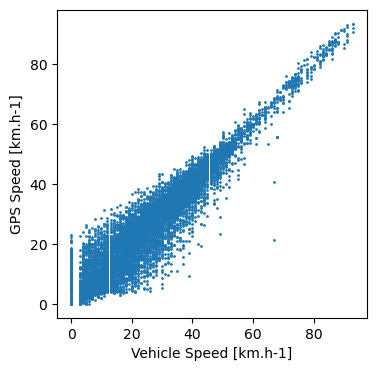

In [19]:
data.plot.scatter(x='Vehicle Speed [km.h-1]', y='GPS Speed [km.h-1]', s=1, figsize=(4, 4))

In PEMS measurements, emissions and particules may have negative values. We assume that they are faulty sensor readings, so we replace these negative values with 0 using `neg_emissions_to_zero()`.

In [20]:
data = neg_emissions_to_zero(data)

## Special processing for some vehicles

`Toyota RAV4 Hybrid 2021 HEV (October 2022)` has 2 exhaust pipes, hence data need to be adjusted. CO2 [%] range should be in 15-20% for HEVs. If it is around 10-11% , then only half of concentration was recorded (for vehicles with 2 exhaust pipes). To adjust, look at the max % for Toyota RAV4 ICEV and HEV. The max is 16.77% for ICEV and 12.942% for HEV, multiply the data by 16.77/12.942=1.295 (instead of multiplying by 2).

In [21]:
if vehicle == 'Toyota RAV4 Hybrid 2021 HEV (October 2022)':
    data['CO2 Conc. [%]'] *= 1.295

Close to the end of the readings, `Toyota Corolla Hybrid 2019 HEV (November 2022)` has negative CO2 and positive FCR values. These instances were manually detected and removed from the data.

In [22]:
if vehicle == 'Toyota Corolla Hybrid 2019 HEV (November 2022)':
    s = data.index[0]
    data = data.loc[s:'2022-11-07 13:30:00']

At the beginning of the `Toyota Prius Prime 2020 PHEV (June 2022)` trip, there is a 20 minute idling. This idling instances and a few readings before this period are removed.

In [23]:
if vehicle == 'Toyota Prius Prime 2020 PHEV (June 2022)':
    data = data.loc['2022-06-30 12:20:15':]

In `KIA Niro 2018 HEV (September 2023)` OBD readings, when engine RPM is 0, mass air flow rate (MAF) is always greater than 1 (regions of fixed values between 1 and 7). For the other HEV trips, we observe that MAF is usually very close to 0 when engine is not running. Therefore, in this trip, we correct MAF values when engine is not running.

In [24]:
if vehicle == 'KIA Niro 2018 HEV (September 2023)':
    mask = data['Engine Speed [rpm]'] == 0
    m = data.loc[mask, 'Mass Air Flow Rate [g.s-1]'].mean()
    data.loc[mask, 'Mass Air Flow Rate [g.s-1]'] = np.maximum(data.loc[mask, 'Mass Air Flow Rate [g.s-1]'] - m, 0)

## Generate new variables

Slope computation: `compute_slope_geodesic_avg()` computes slope with GPS coordinates (Latitude, Longitude, Altitude).

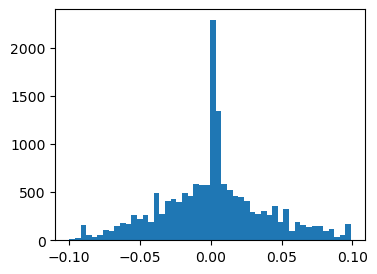

In [25]:
data['Slope [%]'] = compute_slope_geodesic_avg(data, window_size = 5, threshold = 0.1)
hist = data['Slope [%]'].hist(grid=False, figsize=(4, 3), bins=50)

After slope computation, there will be rows with NaN at the top and bottom of the data (due to averaging over a window), remove these rows.

In [26]:
mask = data.index[data.isna().sum(axis=1) == 0]
first = mask[0]
last = mask[-1]
data = data.loc[first:last]
data = data.reset_index().rename(columns={'index':'DateTime'})
data.set_index('DateTime', inplace=True)
print('Data dimensions are :', data.shape)

Data dimensions are : (16040, 17)


Remove idlings at the beginning and end of the readings.

In [27]:
mask = (data['Vehicle Speed [km.h-1]'] == 0) & (data['GPS Speed [km.h-1]'] == 0)
first = next((i for i, j in enumerate(mask) if j == False), None)
last = next((i for i, j in enumerate(reversed(mask)) if j == False), None)
data.drop(data.index[range(0, first)], axis=0, inplace=True)
data.drop(data.index[range(-1, -1*last, -1)], axis=0, inplace=True)
print('After removing idlings data dimensions are :', data.shape)

After removing idlings data dimensions are : (16040, 17)


In OBD readings, Phi and Barometric Pressure measurements might be zero or missing. If Barometric Pressure is missing, set as 100 for all instances. If Phi is missing for some instances, impute them as 1. However, if Phi is missing for all observations, use Fuel Rate1 instead of Fuel Rate2.

In [28]:
mask_bp = data['Barometric Pressure [kpa]'] == 0
if mask_bp.sum() > 0:
    data.loc[mask_bp, 'Barometric Pressure [kpa]'] = 100
    
mask_phi = data['Phi'] == 0
if mask_phi.sum() > 0 and mask_phi.sum() < data.shape[0]:
    data.loc[mask_phi, 'Phi'] = 1

Generate FCR and emission variables with `generate_new_variables()`.

1. Fuel Rate1 [g.s-1] = Fuel Rate [l.h-1] * (Gasoline Density [g.l-1] / 3600)
2. Fuel Rate2 [g.s-1] = MAF [g.s-1] * (Fuel-Air commanded equivalence ratio (Phi) / Stoichiometric air-to-fuel ratio)
3. NO2 [mg.m-3] = NO2 [ppm] * (46.01 / 22.4) * (273 / (273 + temperature)) * (10 * Barometric pressure / 1013)
4. NO [mg.m-3] = NO [ppm] * (30.01 / 22.4) * (273 / (273 + temperature)) * (10 * Barometric pressure / 1013)
5. CO2 [mg.m-3] = CO2 [ppm] * (44.01 / 22.4) * (273 / (273 + temperature)) * (10 * Barometric pressure / 1013)
6. CO [mg.m-3] = CO [ppm] * (28.01 / 22.4) * (273 / (273 + temperature)) * (10 * Barometric pressure / 1013)
7. PM [kg.s-1] = PM [mg.m-3] * 10^(-9) * MAF [g.s-1] / Air density
8. NO2 [kg.s-1] = NO2 [mg.m-3] * 10^(-6) * MAF [g.s-1] * 10^(-3) / Air density
9. NO [kg.s-1] = NO [mg.m-3] * 10^(-6) * MAF [g.s-1] * 10^(-3) / Air density
10. CO2 [kg.s-1] = CO2 [mg.m-3] * 10^(-6) * MAF [g.s-1] * 10^(-3) / Air density
11. CO [kg.s-1] = CO [mg.m-3] * 10^(-6) * MAF [g.s-1] * 10^(-3) / Air density


- Gasoline Density = 718~780 [kg.m-3], which depends on the type of gasoline (whether it is ethanol-based or not, additives, etc.)
- Stoichiometric air-to-fuel ratio for gasoline = 14.7:1
- Air density = 1.2929 [kg.m-3]

In [29]:
data = generate_new_variables(data, gasoline_density = 718)
mask = data['Fuel Rate2 [g.s-1]'] < 0
data.loc[mask, 'Fuel Rate2 [g.s-1]'] = 0

In [30]:
if mask_phi.sum() > 0 and mask_phi.sum() == data.shape[0]:
    data.loc[mask_phi, 'Fuel Rate2 [g.s-1]'] = data.loc[mask_phi, 'Fuel Rate1 [g.s-1]']

if any(data['CO2 Rate [g.s-1]'] < 0):
    raise Exception('There are negative CO2 rate values.')

Outlier detection for FCR and CO2: If there is an extreme outlier, remove that instance from data. 

In [31]:
for v in ['CO2 Rate [g.s-1]', 'Fuel Rate2 [g.s-1]']:
    q1 = data[v].quantile(0.05)
    q3 = data[v].quantile(0.95)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    if any(data[v] > upper):
        mask = data[v] > upper
        data = data.drop(data.index[mask])
        print(mask.sum(), 'outliers are removed and data dimensions are :', data.shape)

14 outliers are removed and data dimensions are : (16026, 23)


Check for missing values after If there is only one missing row between consecutive readings (i.e. 1 second is missing), impute the missing values of the row with the average of its neighbour rows.

In [32]:
data = fill_missing_rows(data)

After missing value imputation data dimensions are : (16028, 23)


## Remove electric battery periods from PHEVs

In [33]:
if 'PHEV' in vehicle and data.iloc[0, data.columns.get_loc('CO2 Rate [g.s-1]')] == 0 and data.iloc[0, data.columns.get_loc('Fuel Rate2 [g.s-1]')] == 0:
    c = 0
    electric = True
    while electric:
        if data.iloc[c, data.columns.get_loc('CO2 Rate [g.s-1]')] == 0 and data.iloc[c, data.columns.get_loc('Fuel Rate2 [g.s-1]')] == 0:
            c += 1
        else:
            electric = False
    if c > 10:
        data.drop(data.index[0:c], inplace=True)
        data = data.reset_index().rename(columns={'index':'DateTime'}).set_index('DateTime')
        print('After removing electric periods data dimensions are :', data.shape)

In [34]:
data.describe().transpose()

count          mean           std  \
Latitude [deg]                           16028.0     45.512329      0.018297   
Longitude [deg]                          16028.0    -73.599628      0.026387   
Altitude [m]                             16028.0     69.359700     30.541718   
GPS Speed [km.h-1]                       16028.0     18.314247     18.502194   
Vehicle Speed [km.h-1]                   16028.0     18.159034     18.396334   
Engine Speed [rpm]                       16028.0    347.348741    658.703891   
Acceleration [m.s-2]                     16028.0      0.000299      0.479231   
Fuel Rate [l.h-1]                        16028.0      0.862441      1.724608   
Intake Air Temperature [c]               16028.0     13.717307      5.402384   
Mass Air Flow Rate [g.s-1]               16028.0      2.520088      5.013666   
Intake Manifold Absolute Pressure [kpa]  16028.0     95.220177     16.061672   
Barometric Pressure [kpa]                16028.0    101.602633      0.630547   
Phi                                      16028.0      0.981114      0.035543   
Ambient Air Temperature [c]              16028.0     13.721862      5.396074   
CO2 Conc. [%]                            16028.0      3.252073      4.949420   
Temperature [c]                          16028.0     36.493020      1.571862   
Slope [%]                                16028.0      0.001762      0.037093   
Fuel Rate1 [g.s-1]                       16028.0      0.172009      0.343963   
Fuel Rate2 [g.s-1]                       16028.0      0.169120      0.338853   
CO2 Conc. [ppm]                          16028.0  32520.725387  49494.201480   
CO2 Conc. [mg.m-3]                       16028.0  56532.068624  86038.526653   
CO2 Rate [kg.s-1]                        16028.0      0.000205      0.000620   
CO2 Rate [g.s-1]                         16028.0      0.204891      0.619667   

                                                  min           25%  \
Latitude [deg]                           4.546984e+01  4.550017e+01   
Longitude [deg]                         -7.365512e+01 -7.362141e+01   
Altitude [m]                             2.030000e+01  5.540000e+01   
GPS Speed [km.h-1]                       0.000000e+00  1.163219e-05   
Vehicle Speed [km.h-1]                   0.000000e+00  0.000000e+00   
Engine Speed [rpm]                       0.000000e+00  0.000000e+00   
Acceleration [m.s-2]                    -2.137772e+00 -2.092355e-01   
Fuel Rate [l.h-1]                        3.993513e-02  4.668502e-02   
Intake Air Temperature [c]               2.000000e+00  1.000000e+01   
Mass Air Flow Rate [g.s-1]               1.200000e-01  1.400000e-01   
Intake Manifold Absolute Pressure [kpa]  1.700000e+01  9.700000e+01   
Barometric Pressure [kpa]                9.900000e+01  1.010000e+02   
Phi                                      6.619415e-01  9.745970e-01   
Ambient Air Temperature [c]              2.000000e+00  1.000000e+01   
CO2 Conc. [%]                            3.700000e-03  2.165000e-01   
Temperature [c]                          3.241000e+01  3.573200e+01   
Slope [%]                               -9.949353e-02 -1.945315e-02   
Fuel Rate1 [g.s-1]                       7.964840e-03  9.311068e-03   
Fuel Rate2 [g.s-1]                       7.103637e-03  9.281876e-03   
CO2 Conc. [ppm]                          3.700000e+01  2.165000e+03   
CO2 Conc. [mg.m-3]                       6.371656e+01  3.775658e+03   
CO2 Rate [kg.s-1]                        6.899465e-09  4.578869e-07   
CO2 Rate [g.s-1]                         6.899465e-06  4.578869e-04   

                                                  50%           75%  \
Latitude [deg]                           4.550870e+01     45.523383   
Longitude [deg]                         -7.359721e+01    -73.577200   
Altitude [m]                             6.200000e+01     74.700000   
GPS Speed [km.h-1]                       1.332585e+01     32.262120   
Vehicle Speed [km.h-1]                   1.300000e+01     32.0

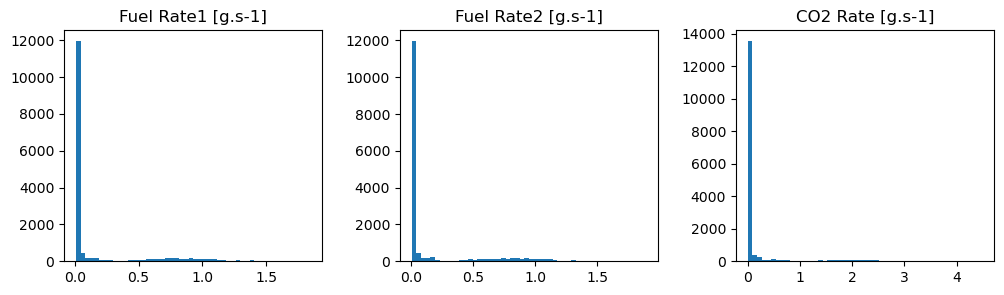

In [35]:
hist = data[['Fuel Rate1 [g.s-1]', 'Fuel Rate2 [g.s-1]', 'CO2 Rate [g.s-1]']].hist(grid=False, figsize=(12,3), bins=50, layout=(1,3))

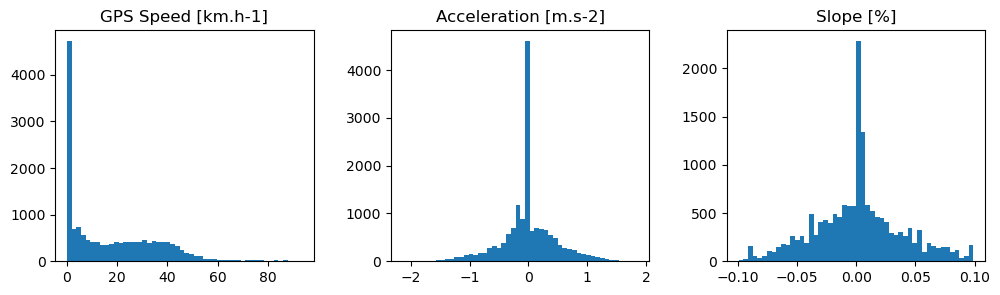

In [36]:
hist = data[['GPS Speed [km.h-1]', 'Acceleration [m.s-2]', 'Slope [%]']].hist(grid=False, figsize=(12,3), bins=50, layout=(1,3))

Time series plots with range slider at the bottom.

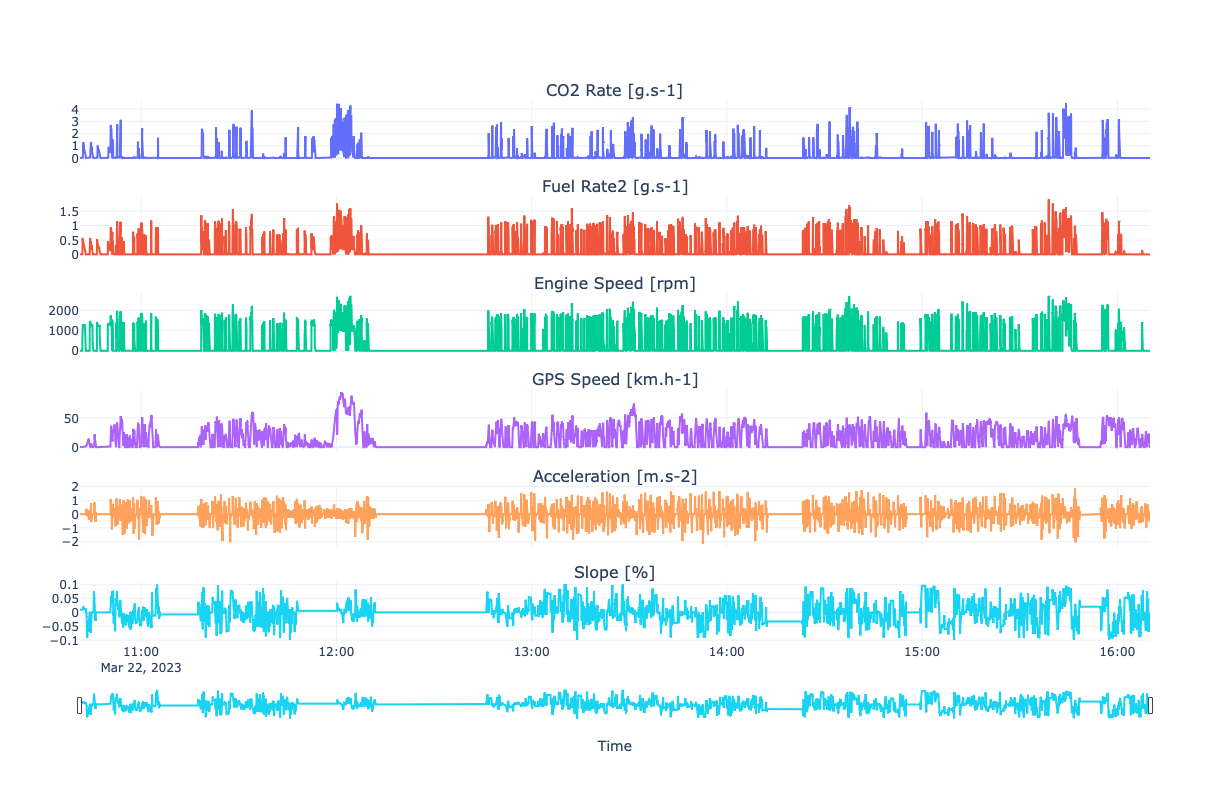

In [37]:
fig = make_subplots(rows=6, cols=1, vertical_spacing=0.065, shared_xaxes=True, 
                    subplot_titles=('CO2 Rate [g.s-1]', 'Fuel Rate2 [g.s-1]', 
                                    'Engine Speed [rpm]', 'GPS Speed [km.h-1]',
                                    'Acceleration [m.s-2]', 'Slope [%]'))
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['CO2 Rate [g.s-1]'])), 1, 1)
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['Fuel Rate2 [g.s-1]'])), 2, 1)
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['Engine Speed [rpm]'])), 3, 1)
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['GPS Speed [km.h-1]'])), 4, 1)
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['Acceleration [m.s-2]'])), 5, 1)
fig.add_trace(
    go.Scatter(x=list(data.index), y=list(data['Slope [%]'])), 6, 1)

fig.update_layout(
    height=800, width=1000, showlegend=False, template='plotly_white',
    xaxis6=dict(title='Time', type='date', rangeslider=dict(visible=True, thickness=0.05)),
)
fig.show()


## Write processed data

In [38]:
isExist = os.path.exists(path_processed_data)
if not isExist:
    # Create processed data directory if it does not exist
    os.makedirs(path_processed_data)
    print('The processed data directory is created.')

filename = vehicle.replace(' ', '_')
path_write = os.path.join(path_processed_data, filename + '.' + 'csv')
data = data.reset_index().rename(columns={'index': 'DateTime'})
data.to_csv(path_write, index=False)